# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1000s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1064, 32, 20, 3)
(1064, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
266/266 [==============================] - 2s 6ms/step - loss: 2.1104 - accuracy: 0.3764
Epoch 2/500
266/266 [==============================] - 2s 6ms/step - loss: 1.3961 - accuracy: 0.5682
Epoch 3/500
266/266 [==============================] - 2s 6ms/step - loss: 0.9765 - accuracy: 0.6836
Epoch 4/500
266/266 [==============================] - 2s 6ms/step - loss: 0.8366 - accuracy: 0.7594
Epoch 5/500
266/266 [==============================] - 2s 6ms/step - loss: 0.6434 - accuracy: 0.8078
Epoch 6/500
266/266 [==============================] - 2s 6ms/step - loss: 0.6254 - accuracy: 0.7878
Epoch 7/500
266/266 [==============================] - 2s 6ms/step - loss: 0.5327 - accuracy: 0.8480
Epoch 8/500
266/266 [==============================] - 2s 7ms/step - loss: 0.4116 - accuracy: 0.8749
Epoch 9/500
266/266 [==============================] - 2s 7ms/step - loss: 0.4994 - accuracy: 0.8521
Epoch 10/500
266/266 [==============================] - 2s 7ms/step - loss: 0.4223 - accura

266/266 [==============================] - 3s 10ms/step - loss: 0.0842 - accuracy: 0.9813
Epoch 81/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0895 - accuracy: 0.9768
Epoch 82/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0602 - accuracy: 0.9785
Epoch 83/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0837 - accuracy: 0.9770
Epoch 84/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0477 - accuracy: 0.9876
Epoch 85/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0966 - accuracy: 0.9773
Epoch 86/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0311 - accuracy: 0.9899
Epoch 87/500
266/266 [==============================] - 3s 10ms/step - loss: 0.1003 - accuracy: 0.9730
Epoch 88/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0557 - accuracy: 0.9820
Epoch 89/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0935 - 

266/266 [==============================] - 3s 13ms/step - loss: 0.0389 - accuracy: 0.9898
Epoch 158/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0217 - accuracy: 0.9933
Epoch 159/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0614 - accuracy: 0.9876
Epoch 160/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0155 - accuracy: 0.9928
Epoch 161/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0364 - accuracy: 0.9928
Epoch 162/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0512 - accuracy: 0.9822
Epoch 163/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0683 - accuracy: 0.9796 0s -
Epoch 164/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0382 - accuracy: 0.9848
Epoch 165/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0528 - accuracy: 0.9840
Epoch 166/500
266/266 [==============================] - 3s 11ms/step - l

266/266 [==============================] - 3s 11ms/step - loss: 0.0224 - accuracy: 0.9954
Epoch 236/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0246 - accuracy: 0.9849
Epoch 237/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0651 - accuracy: 0.9780 1s - loss:
Epoch 238/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0052 - accuracy: 0.9986
Epoch 239/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0444 - accuracy: 0.9928 0s - loss: 0.0410 - 
Epoch 240/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0141 - accuracy: 0.9960
Epoch 241/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0139 - accuracy: 0.9942
Epoch 242/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0112 - accuracy: 0.9953
Epoch 243/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0606 - accuracy: 0.9844
Epoch 244/500
266/266 [=======================

266/266 [==============================] - 3s 11ms/step - loss: 0.0049 - accuracy: 0.9987
Epoch 313/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0190 - accuracy: 0.9946
Epoch 314/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0228 - accuracy: 0.9945
Epoch 315/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0308 - accuracy: 0.9927
Epoch 316/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0091 - accuracy: 0.9986
Epoch 317/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0169 - accuracy: 0.9967
Epoch 318/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0151 - accuracy: 0.9950
Epoch 319/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0058 - accuracy: 0.9979
Epoch 320/500
266/266 [==============================] - 3s 10ms/step - loss: 0.0169 - accuracy: 0.9952
Epoch 321/500
266/266 [==============================] - 3s 12ms/step - loss: 

266/266 [==============================] - 3s 12ms/step - loss: 0.0171 - accuracy: 0.9949
Epoch 390/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0656 - accuracy: 0.9892
Epoch 391/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0087 - accuracy: 0.9979
Epoch 392/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0137 - accuracy: 0.9944
Epoch 393/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0282 - accuracy: 0.9943 0s - loss:
Epoch 394/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0313 - accuracy: 0.9939
Epoch 395/500
266/266 [==============================] - 3s 12ms/step - loss: 0.0575 - accuracy: 0.9944
Epoch 396/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0513 - accuracy: 0.9941
Epoch 397/500
266/266 [==============================] - 3s 11ms/step - loss: 0.0085 - accuracy: 0.9965
Epoch 398/500
266/266 [==============================] - 3s 11ms/st

266/266 [==============================] - 2s 7ms/step - loss: 0.0470 - accuracy: 0.9877
Epoch 468/500
266/266 [==============================] - 2s 7ms/step - loss: 0.0067 - accuracy: 0.9983
Epoch 469/500
266/266 [==============================] - 2s 7ms/step - loss: 0.0232 - accuracy: 0.9948
Epoch 470/500
266/266 [==============================] - 2s 7ms/step - loss: 0.0165 - accuracy: 0.9945
Epoch 471/500
266/266 [==============================] - 2s 8ms/step - loss: 0.0099 - accuracy: 0.9971
Epoch 472/500
266/266 [==============================] - 2s 8ms/step - loss: 0.0222 - accuracy: 0.9946
Epoch 473/500
266/266 [==============================] - 2s 8ms/step - loss: 0.0240 - accuracy: 0.9983
Epoch 474/500
266/266 [==============================] - 2s 7ms/step - loss: 0.0038 - accuracy: 0.9982
Epoch 475/500
266/266 [==============================] - 2s 7ms/step - loss: 0.0087 - accuracy: 0.9971
Epoch 476/500
266/266 [==============================] - ETA: 0s - loss: 0.0033 - accur

### Learing result
 
* Visualization of the training and validation results

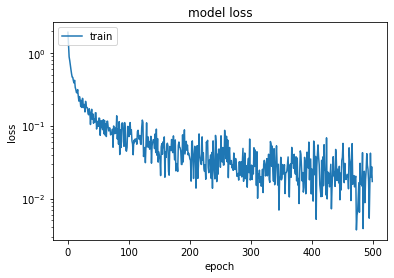

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

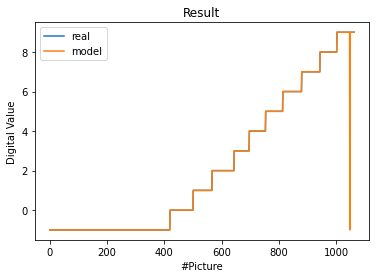

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp3u1w0z0b\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmphj46jerx\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmphj46jerx\assets


203200

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/9\D8_2020-08-20_11-32-19.jpg 9 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.